<a href="https://colab.research.google.com/github/Gookun/RageDetectionv2/blob/main/RageDetectionv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic


In [ ]:
!cp "/content/drive/MyDrive/Dataset" -r "/content/"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing dataset
!unzip Dataset/Dataset.zip

Archive:  Dataset/Dataset.zip
   creating: Dataset/NonRage/
  inflating: Dataset/NonRage/NR_1.mp4  
  inflating: Dataset/NonRage/NR_10.mp4  
  inflating: Dataset/NonRage/NR_11.mp4  
  inflating: Dataset/NonRage/NR_12.mp4  
  inflating: Dataset/NonRage/NR_13.mp4  
  inflating: Dataset/NonRage/NR_14.mp4  
  inflating: Dataset/NonRage/NR_15.mp4  
  inflating: Dataset/NonRage/NR_16.mp4  
  inflating: Dataset/NonRage/NR_2.mp4  
  inflating: Dataset/NonRage/NR_3.mp4  
  inflating: Dataset/NonRage/NR_4.mp4  
  inflating: Dataset/NonRage/NR_5.mp4  
  inflating: Dataset/NonRage/NR_6.mp4  
  inflating: Dataset/NonRage/NR_7.mp4  
  inflating: Dataset/NonRage/NR_8.mp4  
  inflating: Dataset/NonRage/NR_9.mp4  
   creating: Dataset/Rage/
  inflating: Dataset/Rage/R_1.mp4    
  inflating: Dataset/Rage/R_10.mp4   
  inflating: Dataset/Rage/R_11.mp4   
  inflating: Dataset/Rage/R_12.mp4   
  inflating: Dataset/Rage/R_13.mp4   
  inflating: Dataset/Rage/R_14.mp4   
  inflating: Dataset/Rage/R_15.mp4   


In [ ]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False
#checking if tpu is running
if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

Sun Dec 19 05:28:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#defining the head directory
PROJECT_DIR = '/content/Dataset'
!ls {PROJECT_DIR}

NonRage  Rage


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [ ]:
#sample of Rage
play('/content/Dataset/Rage/R_2.mp4')

In [ ]:
#sample of non-Rage
play('/content/Dataset/NonRage/NR_5.mp4')

In [ ]:
"""Preprocessing
Getting frames form video
some image argumentations"""
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [ ]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR
print('we have \n{} Rage videos \n{} NonRage videos'.format(
              len(os.listdir(VideoDataDir + '/Rage')), 
              len(os.listdir(VideoDataDir + '/NonRage'))))

X_original = []
y_original = []

CLASSES = ["NonRage", "Rage"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:350])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)
            
"""use this if there is an checkpoint error (find . -name ".ipynb_checkpoints" -print -delete)"""

we have 
16 Rage videos 
16 NonRage videos


100%|██████████| 16/16 [01:00<00:00,  3.79s/it]

CPU times: user 3min 23s, sys: 2.45 s, total: 3min 25s
Wall time: 2min 5s


In [ ]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

1028

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [ ]:
#Model Training
!pip install imutils
clear_output()

In [ ]:
import pickle
import matplotlib
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout,Flatten,Dense

import matplotlib.pyplot as plt

In [ ]:
epochs = 60

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu 

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [ ]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [ ]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/60
180/180 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.5355
Epoch 00001: val_loss improved from inf to 0.91075, saving model to ModelWeights.h5
180/180 [==============================] - 19s 44ms/step - loss: 0.9344 - accuracy: 0.5355 - val_loss: 0.9108 - val_accuracy: 0.5502 - lr: 1.0000e-05
Epoch 2/60
177/180 [============================>.] - ETA: 0s - loss: 0.8487 - accuracy: 0.5311
Epoch 00002: val_loss improved from 0.91075 to 0.85610, saving model to ModelWeights.h5
180/180 [==============================] - 6s 33ms/step - loss: 0.8525 - accuracy: 0.5285 - val_loss: 0.8561 - val_accuracy: 0.5146 - lr: 1.8000e-05
Epoch 3/60
177/180 [============================>.] - ETA: 0s - loss: 0.8064 - accuracy: 0.5367
Epoch 00003: val_loss improved from 0.85610 to 0.81515, saving model to ModelWeights.h5
180/180 [==============================] - 6s 34ms/step - loss: 0.8018 - accuracy: 0.5369 - val_loss: 0.8152 - val_accuracy: 0.4919 - lr: 2.6000e-05
Epoc

In [ ]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)      

------------------------------------------------------------------------------------------
Best Epochs:  58
Accuracy on train: 0.8678720593452454 	Loss on train: 0.34366375207901
Accuracy on test: 0.8058252334594727 	Loss on test: 0.4020402133464813


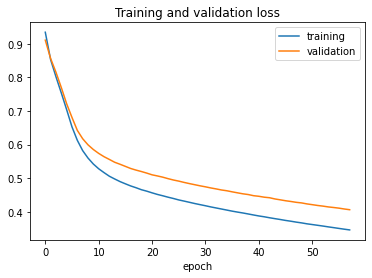

<Figure size 432x288 with 0 Axes>

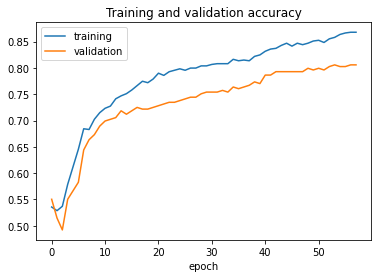

------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:
model_summary(model, history)

In [ ]:
#Evaluation on test set
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...


> Correct Predictions: 249
> Wrong Predictions: 60


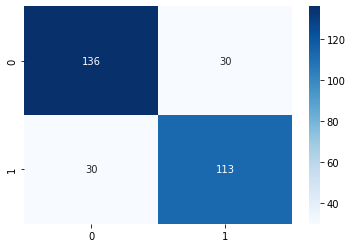

              precision    recall  f1-score   support

     NonRage       0.82      0.82      0.82       166
        Rage       0.79      0.79      0.79       143

    accuracy                           0.81       309
   macro avg       0.80      0.80      0.80       309
weighted avg       0.81      0.81      0.81       309



In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonRage", "Rage"]))

In [ ]:
args_model = "model.h5"
model.save(args_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
#Testing
from keras.models import load_model
from collections import deque

In [ ]:
def print_results(video, limit=None):
        fig=plt.figure(figsize=(16, 30))
        if not os.path.exists('output'):
            os.mkdir('output')

        print("Loading model ...")
        model = load_model('./model.h5')
        Q = deque(maxlen=128)

        vs = cv2.VideoCapture(video)
        writer = None
        (W, H) = (None, None)
        count = 0     
        while True:
                (grabbed, frame) = vs.read()
                ID = vs.get(1)
                if not grabbed:
                    break
                try:
                    if (ID % 7 == 0):
                        count = count + 1
                        n_frames = len(frame)
                        
                        if W is None or H is None:
                            (H, W) = frame.shape[:2]

                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        output = cv2.resize(frame, (512, 360)).copy()
                        frame = cv2.resize(frame, (128, 128)).astype("float32")
                        frame = frame.reshape(IMG_SIZE, IMG_SIZE, 3) / 255
                        preds = model.predict(np.expand_dims(frame, axis=0))[0]
                        Q.append(preds)

                        results = np.array(Q).mean(axis=0)
                        i = (preds > 0.56)[0] #np.argmax(results)

                        label = i

                        text = "Violence: {}".format(label)
                        #print('prediction:', text)
                        file = open("output.txt",'w')
                        file.write(text)
                        file.close()

                        color = (0, 255, 0)

                        if label:
                            color = (255, 0, 0) 
                        else:
                            color = (0, 255, 0)

                        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
                                1, color, 3)


                        # saving mp4 with labels but cv2.imshow is not working with this notebook
                        if writer is None:
                                fourcc = cv2.VideoWriter_fourcc(*"MJPG")
                                writer = cv2.VideoWriter("output.mp4", fourcc, 60,
                                        (W, H), True)

                        writer.write(output)
                        #cv2.imshow("Output", output)

                        fig.add_subplot(8, 3, count)
                        plt.imshow(output)

                    if limit and count > limit:
                        break

                except:
                    break 
        
        plt.show()
        print("Cleaning up...")
        if writer is not None:
            writer.release()
        vs.release()

In [ ]:
#Input
Rage="/content/Dataset/Rage/R_6.mp4" 
play(Rage)

Loading model ...


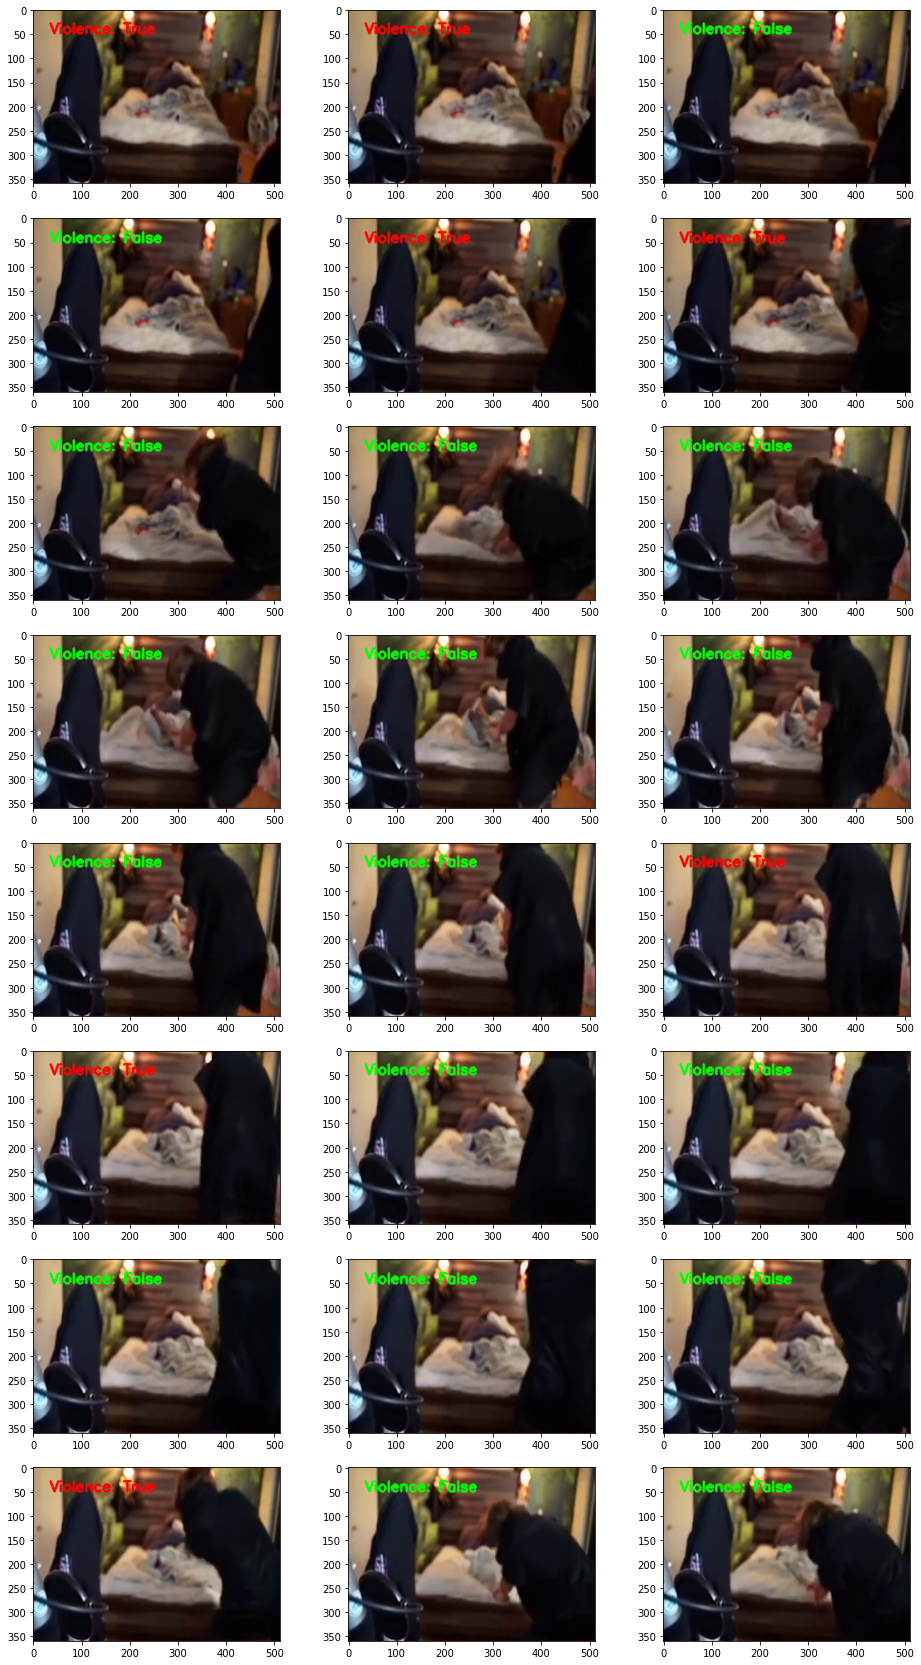

Cleaning up...


In [ ]:
#Output
print_results(Rage, limit=30)

In [ ]:
#Input
NonRage="/content/Dataset/NonRage/NR_7.mp4"
play(NonRage)

In [ ]:
#Output
print_results(NonRage, limit=50)

Loading model ...


In [ ]:
from IPython.display import FileLink
FileLink(r'./model.h5')

/content/model.h5